In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
from sentence_transformers import SentenceTransformer, util
from InstructorEmbedding import INSTRUCTOR
from transformers import AutoModel
import torch
import re
# Excel dosyasını okuma ve "Q-1" sayfasını yükleme
excel_path = 'new_processed-answers.xlsx'
q1_data = pd.read_excel(excel_path, sheet_name='Q-1')

# "Q-1" sayfasının ilk birkaç satırını göstererek veri yapısını kontrol edelim
q1_data.head()


,StudentID,Answer,Score
0,20190808014,arabs contributed important concepts like opti...,20
1,20190808021,ali ku credit u proved astronomical facts evid...,8
2,20190808035,estimate number days year geography need know ...,4
3,20200808003,samarkand school geography astronomy provided ...,14
4,20200808008,glass optics omar khayyam described laws refle...,18


In [4]:
# Verilen pluskeywords ve pluspoints listelerini kullanarak bir sözlük yapısı oluşturulacak
pluskeywords =  [
    ['optic','refract||reflect||transmis','lens:4'],
    ['algorithm','alcho','quaran','algebra:2'],
    ['cartog||map&&make','map&&piri||reis','time||pray||mecce||mekke||makka'],
    ['transla', 'library:3','wisdom&&house','collect&&know','save&&know'],
    ['ibn&&sina','surgery','blood&&circula','circul:2']
]

pluspoints = [8, 4, 4, 6, 4]

# Anahtar kelimeleri ve puanları birleştiren bir sözlük yapısı oluştur
plus_keyword_points = {tuple(group): point for group, point in zip(pluskeywords, pluspoints)}

plus_keyword_points


{('optic', 'refract||reflect||transmis', 'lens:4'): 8,
 ('algorithm', 'alcho', 'quaran', 'algebra:2'): 4,
 ('cartog||map&&make',
  'map&&piri||reis',
  'time||pray||mecce||mekke||makka'): 4,
 ('transla', 'library:3', 'wisdom&&house', 'collect&&know', 'save&&know'): 6,
 ('ibn&&sina', 'surgery', 'blood&&circula', 'circul:2'): 4}

In [7]:
# Maksimum 20 puanla sınırlı olarak cevapları değerlendirme ve puanlama fonksiyonu
def evaluate_answers_max_20(answers, keywords_points):
    evaluated_scores_max_20 = []  # Hesaplanan puanların saklandığı liste
    
    # Her bir cevabı dolaş
    for answer in answers:
        # Cevabı string olarak garanti altına al
        answer_str = str(answer)
        total_score = 0  # Her bir cevap için toplam puan
        
        # Anahtar kelime gruplarını ve puanlarını dolaş
        for keywords, points in keywords_points.items():
            # Her bir anahtar kelime grubu için cevapta arama yap
            for keyword in keywords:
                if '||' in keyword:
                    for sub_keyword in keyword.split('||'):
                        if re.search(sub_keyword, answer_str, re.IGNORECASE):
                            total_score += points
                            break
                elif '&&' in keyword:
                    all_found = all(re.search(sub_keyword, answer_str, re.IGNORECASE) for sub_keyword in keyword.split('&&'))
                    if all_found:
                        total_score += points
                elif ':' in keyword:
                    word, count = keyword.split(':')
                    found_count = len(re.findall(word, answer_str, re.IGNORECASE))
                    total_score += min(int(count), found_count) * points
                else:
                    if re.search(keyword, answer_str, re.IGNORECASE):
                        total_score += points
        
        # Toplam puanı 20 ile sınırlandır
        total_score = min(total_score, 20)
        evaluated_scores_max_20.append(total_score)
    
    return evaluated_scores_max_20

# Anahtar kelime gruplarına göre öğrenci cevaplarını değerlendir ve puanları hesapla (maksimum 20 puanla sınırlı)
evaluated_scores_max_20 = evaluate_answers_max_20(q1_data['Answer'], plus_keyword_points)

# İlk birkaç hesaplanan puanı göster
#evaluated_scores_max_20


In [11]:
# Öğrenci numarası, orijinal skor, ve yapılan değerlendirme sonuçlarını içeren bir DataFrame oluşturma
results_df = pd.DataFrame({
    "StudentID": q1_data['StudentID'],
    "Original Score": q1_data['Score'],
    "Evaluated Score": evaluated_scores_max_20
})

results_df.head()


,StudentID,Original Score,Evaluated Score
0,20190808014,20,20
1,20190808021,8,8
2,20190808035,4,4
3,20200808003,14,20
4,20200808008,18,20


In [12]:
# Original Score ve Evaluated Score arasındaki korelasyonu hesaplama
correlation = results_df['Original Score'].corr(results_df['Evaluated Score'])

correlation


0.9477717030389234

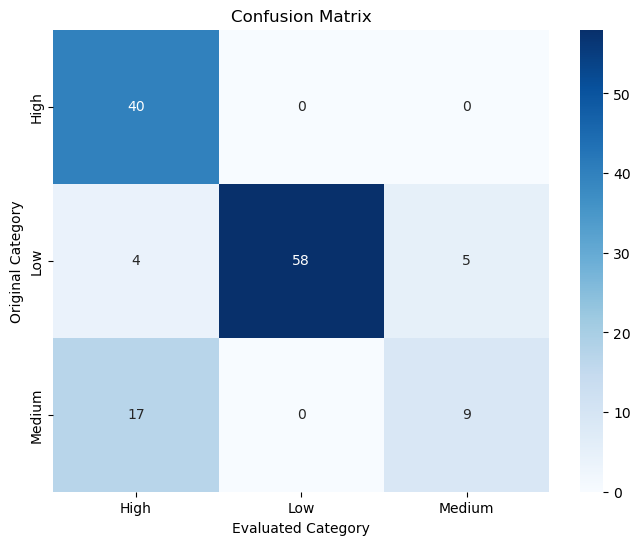

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Skorları kategorilere ayırma fonksiyonu
def categorize_scores(scores):
    bins = [0, 10, 15, 20]
    labels = ['Low', 'Medium', 'High']
    categories = pd.cut(scores, bins, labels=labels, include_lowest=True)
    return categories

# Original ve Evaluated Score'ları kategorilere ayır
results_df['Original Category'] = categorize_scores(results_df['Original Score'])
results_df['Evaluated Category'] = categorize_scores(results_df['Evaluated Score'])

# Kategori sayısal değerlere dönüştürme
le = LabelEncoder()
results_df['Original Category Encoded'] = le.fit_transform(results_df['Original Category'])
results_df['Evaluated Category Encoded'] = le.transform(results_df['Evaluated Category'])

# Confusion matrisi hesaplama
cm = confusion_matrix(results_df['Original Category Encoded'], results_df['Evaluated Category Encoded'])

# Confusion matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Evaluated Category')
plt.ylabel('Original Category')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Yeni anahtar kelimeler ve puanlar
pluskeywords_q2 = [
    ['engineer','science','technology','question&&nature','ask&&why','evidence||proof','open&&mind'],
    ['road||highway','tranport','travel||road&&network'],
    ['aqueduct','concrete','arch'],
    ['newspaper','theater&&influen||entert','culture:2'],
    ['calendar'],
    ['division&&power','consul||senate||assemb:3','republic'],
    ['battlefield','welfare'],
    ['12&&table','legal', 'democracy','foreign&&trade','conflict']
]

pluspoints_q2 = [7, 4, 4, 2, 2, 3, 3, 3]

# Anahtar kelimeleri ve puanları birleştiren yeni bir sözlük yapısı oluşturma
plus_keyword_points_q2 = {tuple(group): point for group, point in zip(pluskeywords_q2, pluspoints_q2)}

plus_keyword_points_q2


{('engineer',
  'science',
  'technology',
  'question&&nature',
  'ask&&why',
  'evidence||proof',
  'open&&mind'): 7,
 ('road||highway', 'tranport', 'travel||road&&network'): 4,
 ('aqueduct', 'concrete', 'arch'): 4,
 ('newspaper', 'theater&&influen||entert', 'culture:2'): 2,
 ('calendar',): 2,
 ('division&&power', 'consul||senate||assemb:3', 'republic'): 3,
 ('battlefield', 'welfare'): 3,
 ('12&&table', 'legal', 'democracy', 'foreign&&trade', 'conflict'): 3}

In [15]:
# "Q-2" sayfasındaki verileri yükleyelim
q2_data = pd.read_excel(excel_path, sheet_name='Q-2')

# "Q-2" sayfasındaki verilerin ilk birkaç satırını kontrol edelim
q2_data.head()


,StudentID,Answer,Score
0,20190808014,advanced modern legal system civil engineering...,17
1,20190808021,main battlefield surgeries bound books 12 tabl...,18
2,20190808035,roads highways geometry military engineering s...,11
3,20200808003,NaN,0
4,20200808008,achieved civil army engineering republic gover...,17


In [16]:
# "Q-2" sayfasındaki öğrenci cevaplarını değerlendir ve puanları hesapla (maksimum 20 puanla sınırlı)
evaluated_scores_q2 = evaluate_answers_max_20(q2_data['Answer'], plus_keyword_points_q2)

# Öğrenci numarası, orijinal skor, ve yapılan değerlendirme sonuçlarını içeren bir DataFrame oluşturma
results_df_q2 = pd.DataFrame({
    "StudentID": q2_data['StudentID'],
    "Original Score": q2_data['Score'],
    "Evaluated Score": evaluated_scores_q2
})

results_df_q2.head()


,StudentID,Original Score,Evaluated Score
0,20190808014,17,20
1,20190808021,18,20
2,20190808035,11,18
3,20200808003,0,0
4,20200808008,17,20


Correlation between Original Score and Evaluated Score for Q-2: 0.9370565969785662


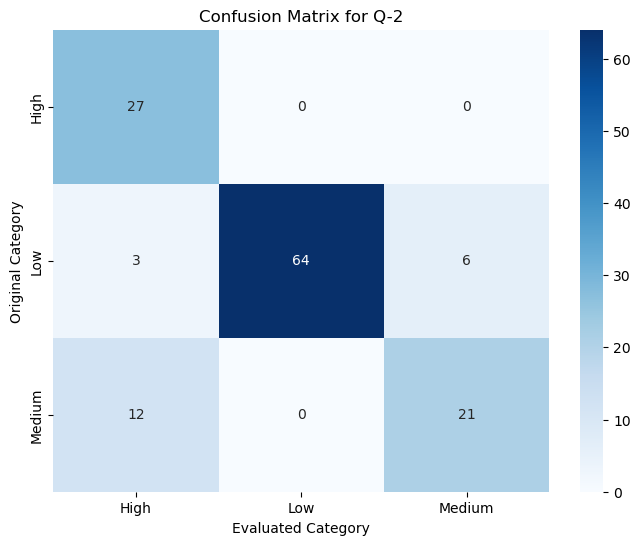

In [17]:
# "Q-2" için Original Score ve Evaluated Score arasındaki korelasyonu hesaplama
correlation_q2 = results_df_q2['Original Score'].corr(results_df_q2['Evaluated Score'])

# Korelasyonu göster
print(f"Correlation between Original Score and Evaluated Score for Q-2: {correlation_q2}")

# "Q-2" için kategorilere ayırma ve confusion matrisi hesaplama
results_df_q2['Original Category'] = categorize_scores(results_df_q2['Original Score'])
results_df_q2['Evaluated Category'] = categorize_scores(results_df_q2['Evaluated Score'])

# Kategori sayısal değerlere dönüştürme için LabelEncoder kullanma
results_df_q2['Original Category Encoded'] = le.fit_transform(results_df_q2['Original Category'])
results_df_q2['Evaluated Category Encoded'] = le.transform(results_df_q2['Evaluated Category'])

# Confusion matrisi hesaplama
cm_q2 = confusion_matrix(results_df_q2['Original Category Encoded'], results_df_q2['Evaluated Category Encoded'])

# Confusion matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_q2, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Evaluated Category')
plt.ylabel('Original Category')
plt.title('Confusion Matrix for Q-2')
plt.show()


In [18]:
# Artı ve eksi anahtar kelimeler için sözlük yapıları
pluskeywords_q3 = [
    ['innoc&&guilty&&prove','guilty:6'],
    ['jury','trail','juri','judge','court'],
    ['precedent','prev&&judg','prev&&case','12&&table','twelve&&table','lawyer']
]
pluspoints_q3 = [8, 8, 8]

minuskeywords_q3 = [
    ['consul','assemb','senat'],
    ['conflict&&interest']
]
minuspoints_q3 = [5, 5]

# Artı puanlar için anahtar kelime gruplarını ve puanlarını birleştiren sözlük
plus_keyword_points_q3 = {tuple(group): point for group, point in zip(pluskeywords_q3, pluspoints_q3)}

# Eksi puanlar için anahtar kelime gruplarını ve puanlarını birleştiren sözlük
minus_keyword_points_q3 = {tuple(group): -point for group, point in zip(minuskeywords_q3, minuspoints_q3)}

# Artı ve eksi puanları birleştiren genel sözlük yapısı
keywords_points_q3 = {**plus_keyword_points_q3, **minus_keyword_points_q3}

keywords_points_q3


{('innoc&&guilty&&prove', 'guilty:6'): 8,
 ('jury', 'trail', 'juri', 'judge', 'court'): 8,
 ('precedent',
  'prev&&judg',
  'prev&&case',
  '12&&table',
  'twelve&&table',
  'lawyer'): 8,
 ('consul', 'assemb', 'senat'): -5,
 ('conflict&&interest',): -5}

In [21]:
# "Q-3" sayfasındaki verileri yükleyelim
q3_data = pd.read_excel(excel_path, sheet_name='Q-3')

# Artı ve eksi puanlamaları dikkate alarak cevapları değerlendirme ve puanlama fonksiyonu
def evaluate_answers_with_minus(answers, keywords_points):
    evaluated_scores_with_minus = []  # Hesaplanan puanların saklandığı liste
    
    # Her bir cevabı dolaş
    for answer in answers:
        # Cevabı string olarak garanti altına al
        answer_str = str(answer)
        total_score = 0  # Her bir cevap için toplam puan
        
        # Anahtar kelime gruplarını ve puanlarını dolaş
        for keywords, points in keywords_points.items():
            # Her bir anahtar kelime grubu için cevapta arama yap
            for keyword in keywords:
                if '||' in keyword or '&&' in keyword or ':' in keyword:
                    # Özel durumlar için regex kullanarak eşleşme kontrolü
                    if check_match(answer_str, keyword):
                        total_score += points
                else:
                    # Basit kelime araması
                    if re.search(keyword, answer_str, re.IGNORECASE):
                        total_score += points
        
        # Toplam puanı 20 ile sınırlandır ve eksi puanları uygula
        total_score = max(min(total_score, 20), 0)
        evaluated_scores_with_minus.append(total_score)
    
    return evaluated_scores_with_minus

# Özel durumlar için eşleşme kontrol fonksiyonu
def check_match(answer, keyword):
    if '||' in keyword:
        return any(re.search(part, answer, re.IGNORECASE) for part in keyword.split('||'))
    elif '&&' in keyword:
        return all(re.search(part, answer, re.IGNORECASE) for part in keyword.split('&&'))
    elif ':' in keyword:
        word, count = keyword.split(':')
        return len(re.findall(word, answer, re.IGNORECASE)) >= int(count)
    return False

# "Q-3" sayfasındaki öğrenci cevaplarını değerlendir ve puanları hesapla
evaluated_scores_q3 = evaluate_answers_with_minus(q3_data['Answer'], keywords_points_q3)

# Öğrenci numarası, orijinal skor, ve yapılan değerlendirme sonuçlarını içeren bir DataFrame oluşturma
results_df_q3 = pd.DataFrame({
    "StudentID": q3_data['StudentID'],
    "Original Score": q3_data['Score'],
    "Evaluated Score": evaluated_scores_q3
})

# Korelasyon ve confusion matrisi için hazırlık
results_df_q3['Original Category'] = categorize_scores(results_df_q3['Original Score'])
results_df_q3['Evaluated Category'] = categorize_scores(results_df_q3['Evaluated Score'])
results_df_q3['Original Category Encoded'] = le.fit_transform(results_df_q3['Original Category'])
results_df_q3['Evaluated Category Encoded'] = le.transform(results_df_q3['Evaluated Category'])

# Korelasyon hesaplama
correlation_q3 = results_df_q3['Original Score'].corr(results_df_q3['Evaluated Score'])

# Confusion matrisi hesaplama
cm_q3 = confusion_matrix(results_df_q3['Original Category Encoded'], results_df_q3['Evaluated Category Encoded'])

# Sonuçları göster
correlation_q3, cm_q3



(0.8654347362598629,
 array([[41,  7,  3],
        [ 0, 76,  1],
        [ 1,  4,  0]]))

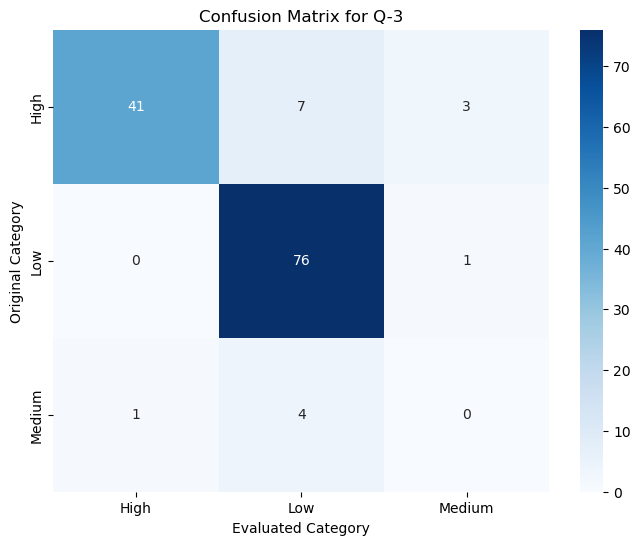

In [22]:
# Confusion matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_q3, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Evaluated Category')
plt.ylabel('Original Category')
plt.title('Confusion Matrix for Q-3')
plt.show()

In [23]:
# Q-4 için anahtar kelimeler ve puanlar
pluskeywords_q4 = [
    ['shadow&&angle','shadow&&degree','shadow&&stick','perimeter:6','circum:6'],
    ['eclips','arist','coin','appear','disappear','ratio'],
    ['euclid','thales','pythag','project']
]
pluspoints_q4 = [8, 8, 8]

# Anahtar kelimeleri ve puanları birleştiren sözlük
plus_keyword_points_q4 = {tuple(group): point for group, point in zip(pluskeywords_q4, pluspoints_q4)}

# "Q-4" sayfasındaki verileri yükleyelim
q4_data = pd.read_excel(excel_path, sheet_name='Q-4')

# "Q-4" sayfasındaki öğrenci cevaplarını değerlendir ve puanları hesapla
evaluated_scores_q4 = evaluate_answers_with_minus(q4_data['Answer'], plus_keyword_points_q4)

# Öğrenci numarası, orijinal skor, ve yapılan değerlendirme sonuçlarını içeren bir DataFrame oluşturma
results_df_q4 = pd.DataFrame({
    "StudentID": q4_data['StudentID'],
    "Original Score": q4_data['Score'],
    "Evaluated Score": evaluated_scores_q4
})

# Korelasyon ve confusion matrisi için hazırlık
results_df_q4['Original Category'] = categorize_scores(results_df_q4['Original Score'])
results_df_q4['Evaluated Category'] = categorize_scores(results_df_q4['Evaluated Score'])
results_df_q4['Original Category Encoded'] = le.fit_transform(results_df_q4['Original Category'])
results_df_q4['Evaluated Category Encoded'] = le.transform(results_df_q4['Evaluated Category'])

# Korelasyon hesaplama
correlation_q4 = results_df_q4['Original Score'].corr(results_df_q4['Evaluated Score'])

# Confusion matrisi hesaplama
cm_q4 = confusion_matrix(results_df_q4['Original Category Encoded'], results_df_q4['Evaluated Category Encoded'])

# Sonuçları göster
correlation_q4, cm_q4


(0.9436145173220843,
 array([[35,  0,  0],
        [ 7, 90,  0],
        [ 1,  0,  0]]))

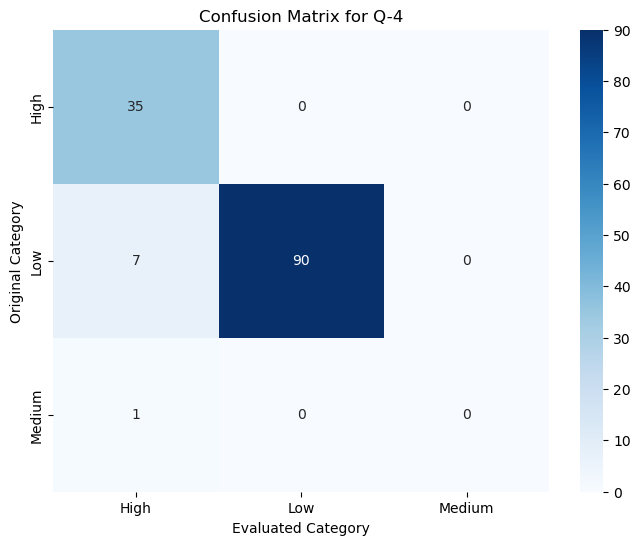

In [24]:
# Confusion matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_q4, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Evaluated Category')
plt.ylabel('Original Category')
plt.title('Confusion Matrix for Q-4')
plt.show()


In [25]:
# Q-5 için anahtar kelimeler ve puanlar
pluskeywords_q5 = [
    ['withdraw', 'pull', 'reject', 'disprove', 'check', 'control', 'reevaluate', 'mistake', 'accept', 'antithesis', 'anti&&thes', 'analy:5'],
    ['propose&&new', 'revise', 'modify', 'change', 'rearrange', 'update', 'alternative', 'new&&hypot']
]
pluspoints_q5 = [10, 10]

# Anahtar kelimeleri ve puanları birleştiren sözlük
plus_keyword_points_q5 = {tuple(group): point for group, point in zip(pluskeywords_q5, pluspoints_q5)}

# "Q-5" sayfasındaki verileri yükleyelim
q5_data = pd.read_excel(excel_path, sheet_name='Q-5')

# "Q-5" sayfasındaki öğrenci cevaplarını değerlendir ve puanları hesapla
evaluated_scores_q5 = evaluate_answers_with_minus(q5_data['Answer'], plus_keyword_points_q5)

# Öğrenci numarası, orijinal skor, ve yapılan değerlendirme sonuçlarını içeren bir DataFrame oluşturma
results_df_q5 = pd.DataFrame({
    "StudentID": q5_data['StudentID'],
    "Original Score": q5_data['Score'],
    "Evaluated Score": evaluated_scores_q5
})

# Korelasyon ve confusion matrisi için hazırlık
results_df_q5['Original Category'] = categorize_scores(results_df_q5['Original Score'])
results_df_q5['Evaluated Category'] = categorize_scores(results_df_q5['Evaluated Score'])
results_df_q5['Original Category Encoded'] = le.fit_transform(results_df_q5['Original Category'])
results_df_q5['Evaluated Category Encoded'] = le.transform(results_df_q5['Evaluated Category'])

# Korelasyon hesaplama ve confusion matrisi oluşturma işlemlerini gerçekleştirelim.
correlation_q5 = results_df_q5['Original Score'].corr(results_df_q5['Evaluated Score'])
cm_q5 = confusion_matrix(results_df_q5['Original Category Encoded'], results_df_q5['Evaluated Category Encoded'])

correlation_q5, cm_q5


(0.9113566356053083,
 array([[  5,   0],
        [ 15, 113]]))

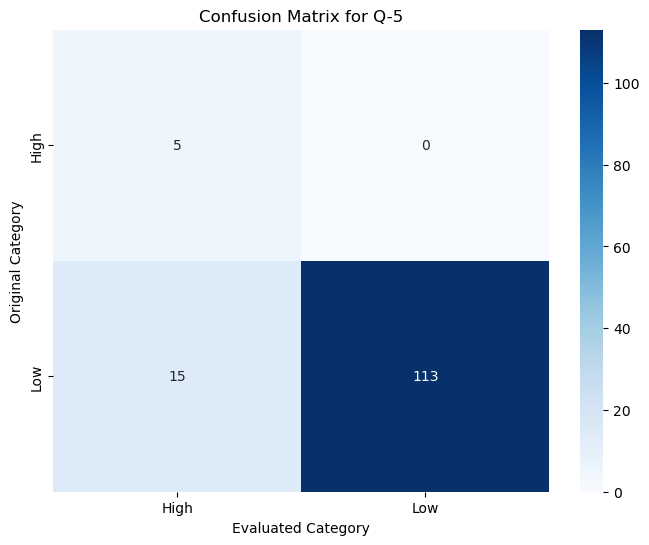

In [26]:
# Confusion matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_q5, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Evaluated Category')
plt.ylabel('Original Category')
plt.title('Confusion Matrix for Q-5')
plt.show()


In [28]:
# Beş DataFrame'i birleştirme ve yeni bir DataFrame oluşturma
all_results_df = pd.concat([results_df, results_df_q2, results_df_q3, results_df_q4, results_df_q5])

# Öğrenci numarasına göre gruplama ve toplam orijinal skor ile toplam değerlendirilmiş skoru hesaplama
total_scores_df = all_results_df.groupby('StudentID').agg(
    Total_Original_Score=('Original Score', 'sum'),
    Total_Evaluated_Score=('Evaluated Score', 'sum')
).reset_index()

total_scores_df


,StudentID,Total_Original_Score,Total_Evaluated_Score
0,20190808014,75,78
1,20190808021,78,84
2,20190808035,33,40
3,20200808003,34,40
4,20200808008,81,96
...,...,...,...
128,20230808615,70,74
129,20230808617,55,55
130,20230808618,54,66
131,20230808621,66,72


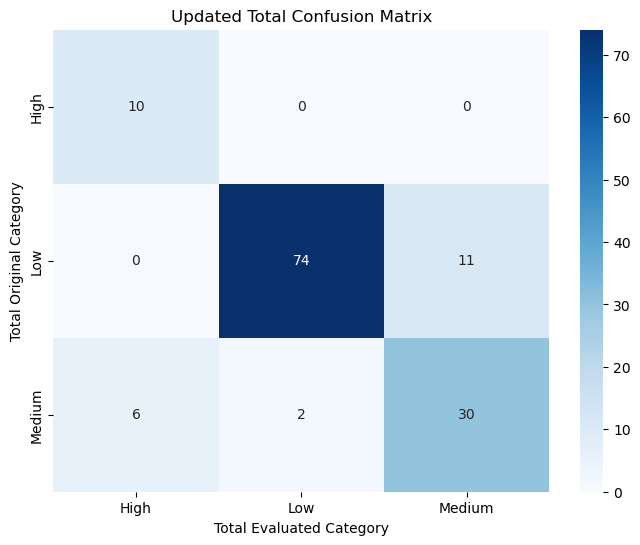

In [29]:
# Toplam skorların kategorilere ayrılmasını ve kodlanmasını tekrar kontrol etme
# Kategorilere ayrılma işlemi tekrar yapılıyor
total_scores_df['Total Original Category'] = pd.cut(total_scores_df['Total_Original_Score'], bins=[0, 50, 75, 100], labels=['Low', 'Medium', 'High'], include_lowest=True)
total_scores_df['Total Evaluated Category'] = pd.cut(total_scores_df['Total_Evaluated_Score'], bins=[0, 50, 75, 100], labels=['Low', 'Medium', 'High'], include_lowest=True)

# Kategori sayısal değerlere dönüştürme işlemi tekrar yapılıyor
total_scores_df['Total Original Category Encoded'] = le.fit_transform(total_scores_df['Total Original Category'].astype(str))
total_scores_df['Total Evaluated Category Encoded'] = le.transform(total_scores_df['Total Evaluated Category'].astype(str))

# Confusion matrisi tekrar hesaplanıyor
cm_total_updated = confusion_matrix(total_scores_df['Total Original Category Encoded'], total_scores_df['Total Evaluated Category Encoded'])

# Confusion matrisini tekrar görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_total_updated, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Total Evaluated Category')
plt.ylabel('Total Original Category')
plt.title('Updated Total Confusion Matrix')
plt.show()


In [30]:
# Güncellenmiş korelasyonu hesaplama
total_correlation_updated = total_scores_df['Total_Original_Score'].corr(total_scores_df['Total_Evaluated_Score'])

total_correlation_updated


0.9579073771110996